## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [1]:
!pip install tensorflow==2.12.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#Scikit-Learn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#Imbalanced-Learn
from imblearn.under_sampling import RandomUnderSampler


**QUESTION:** Load dataset and display some lines of the csv file.

In [2]:
data_path = "/content/ai4i2020.csv"

df = pd.read_csv(data_path)

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

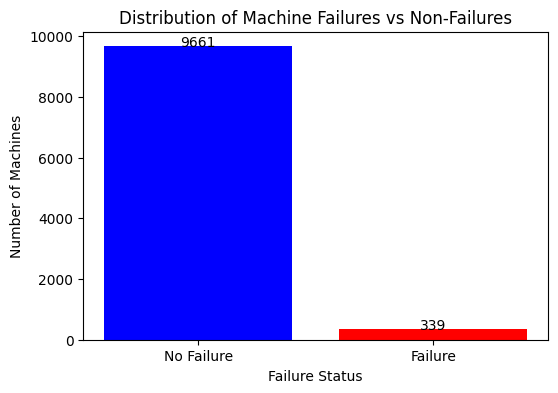

In [3]:

counts_machine_failure = df['Machine failure'].value_counts()

labels = ['No Failure', 'Failure']
values = [counts_machine_failure.get(0, 0), counts_machine_failure.get(1, 0)]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['blue', 'red'])
plt.title("Distribution of Machine Failures vs Non-Failures")
plt.xlabel("Failure Status")
plt.ylabel("Number of Machines")

for i, v in enumerate(values):
    plt.text(i, v + 0.5, str(int(v)), ha='center')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

There are many more machines without failures compared to machines that experienced failures.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Subsequently, training the AI on such imbalanced data may result in a model that performs well in identifying non-failure cases, but poorly in detecting actual failures.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

<ipython-input-4-235485598937>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['blue', 'orange', 'green', 'red', 'purple'] )


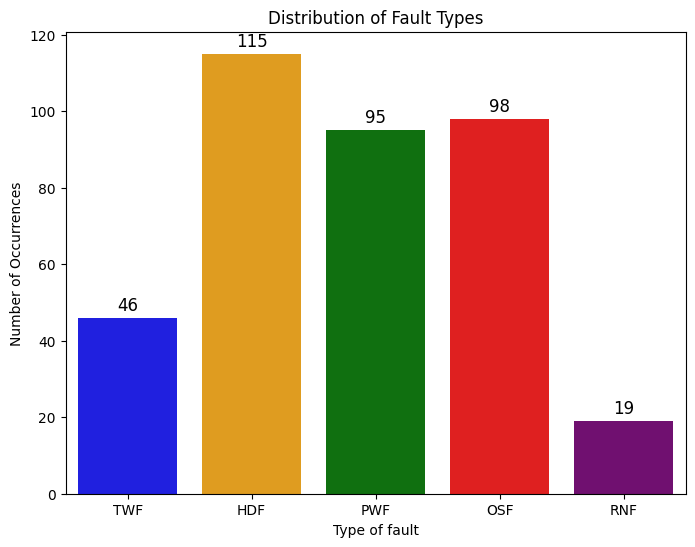

In [4]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_types].sum()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['blue', 'orange', 'green', 'red', 'purple'] )

for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Type of fault")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Fault Types")

plt.show()

**ANALYSIS QUESTION:** What do you observe?

Even when comparing only the machines that experienced failures, there is still a noticeable imbalance among the types of failures: 19 were categorized as RNF and 115 as HDF. However, RNF will be removed from the dataset since it represents random failures, leaving TWF as a failure type with a significant discrepancy compared to the others.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

<ipython-input-5-708757154ff1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values,  palette=['blue', 'orange', 'green', 'red', 'purple', 'gray'])


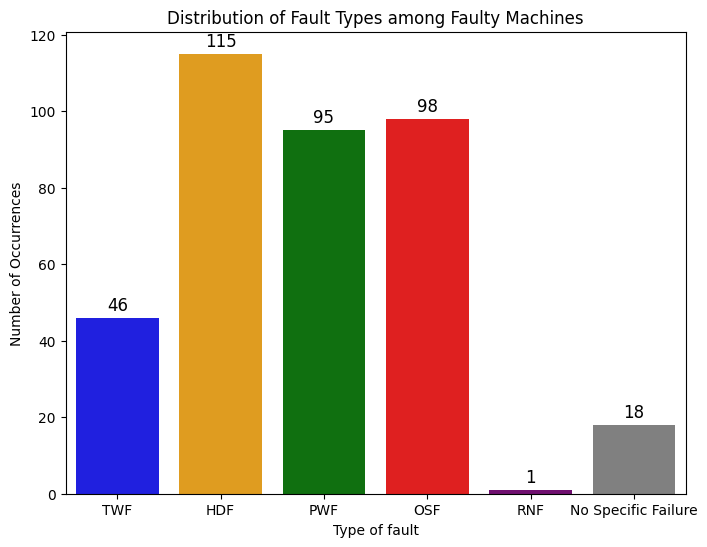

In [5]:
failed_machines = df[df["Machine failure"] == 1]

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = failed_machines[failure_types].sum()

no_specific_failure = df[(df["Machine failure"] == 0) & (df["RNF"] == 1)].shape[0]

failure_counts["No Specific Failure"] = no_specific_failure

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=failure_counts.index, y=failure_counts.values,  palette=['blue', 'orange', 'green', 'red', 'purple', 'gray'])

for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Type of fault")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Fault Types among Faulty Machines")

plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Once again, there is a discrepancy in the number of samples among the machines that experienced failures. Within the RNF category, most of them were actually No Specific Failures.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [6]:
print("Column Names and Data Types:")
print(df.dtypes)

Column Names and Data Types:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to use previous results to justify your response.

To train the model, the chosen input variables will be those that indicate the machine's usage and physical conditions, such as Air temperature, Process temperature, Rotational speed, Torque, Tool wear, and Type, as they directly influence performance and the occurrence of failures.
The output variables will consist of the No failure column (created to represent cases where no failure occurred) and the columns of specific failure types such as TWF, HDF, PWF, and OSF.
The RNF column was removed, because in addition to representing random failures, its amount is negligible compared to the others.
Since the goal is to indicate the type of failure that occurred, the Machine failure column will be replaced by No failure, as this becomes more viable, given that the specific failure columns already indicate whether a failure occurred and what type it was, avoiding redundancies in the model.



## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [7]:
# Create dummy variables for the 'Type' column
df = pd.get_dummies(df, columns=['Type'], drop_first=False)

In [8]:
#  Failure types
failure_types = ['TWF', 'HDF', 'PWF', 'OSF']

#  Remove samples with more than one specific failure
df['sum_failures'] = df[failure_types].sum(axis=1)
df = df[(df['Machine failure'] == 0) | ((df['Machine failure'] == 1) & (df['sum_failures'] == 1))]
df.drop(columns='sum_failures', inplace=True)

#  Create "No failure" column
df['No failure'] = (df['Machine failure'] == 0).astype(int)

#  Copy columns as Y base
Y = df[['No failure', 'TWF', 'HDF', 'PWF', 'OSF']].copy()

Y = Y.apply(lambda row: (row == 1).astype(int), axis=1)

#  Define X (remove output and irrelevant columns)
df = df.drop(columns=['class'], errors='ignore')
X = df.drop(columns=['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'No failure'])

#  Normalize X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

#  Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y.values.argmax(axis=1))

#  Show dimensions
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

print("\nX:")

print(X.head())

print("\nY:")

print(Y.head())


X_train shape: (6977, 8), Y_train shape: (6977, 5)
X_test shape: (2991, 8), Y_test shape: (2991, 5)

X:
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0             0.304348                 0.358025                0.222934   
1             0.315217                 0.370370                0.139697   
2             0.304348                 0.345679                0.192084   
3             0.315217                 0.358025                0.154249   
4             0.315217                 0.370370                0.139697   

   Torque [Nm]  Tool wear [min]  Type_H  Type_L  Type_M  
0     0.535714         0.000000     0.0     0.0     1.0  
1     0.583791         0.011952     0.0     1.0     0.0  
2     0.626374         0.019920     0.0     1.0     0.0  
3     0.490385         0.027888     0.0     1.0     0.0  
4     0.497253         0.035857     0.0     1.0     0.0  

Y:
   No failure  TWF  HDF  PWF  OSF
0           1    0    0    0    0
1           1    0    0  

Number of samples with only one specific failure: 307


<ipython-input-9-00322e3f3bc4>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=remaining_failure_counts.index, y=remaining_failure_counts.values,


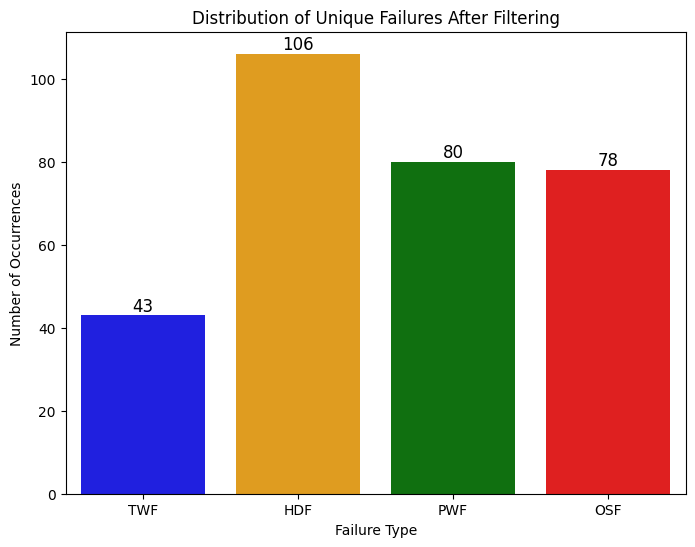

In [9]:
# Specific failure types
failure_types = ['TWF', 'HDF', 'PWF', 'OSF']

# Create column with the sum of failures per row
df['sum_failures'] = df[failure_types].sum(axis=1)

# Filter only machines with failure AND a single specific failure
filtered_failures = df[(df['Machine failure'] == 1) & (df['sum_failures'] == 1)]

# Count how many unique samples remain
num_remaining = filtered_failures.shape[0]
print(f"Number of samples with only one specific failure: {num_remaining}")

# Count how many of each failure type exist in the filtered samples
remaining_failure_counts = filtered_failures[failure_types].sum()

# Plot the distribution of failure types
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=remaining_failure_counts.index, y=remaining_failure_counts.values,
                 palette=['blue', 'orange', 'green', 'red'])

# Add values above the bars
for i, value in enumerate(remaining_failure_counts.values):
    ax.text(i, value + 1, str(int(value)), ha='center', fontsize=12)

plt.xlabel("Failure Type")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Unique Failures After Filtering")
plt.show()

# Remove the auxiliary column
df.drop(columns='sum_failures', inplace=True)






**QUESTION** Code below the model architecture

In [10]:
# Model for multi-class classification (5 exclusive outputs)
model = Sequential([
    Dense(64, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),

    Dense(32, kernel_regularizer=l2(0.01)),
    LeakyReLU(),
    Dropout(0.2),

    Dense(5, activation='softmax')  #  using softmax for exclusive multi-class
])

# Compilation with categorical_crossentropy
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.02),
    loss='categorical_crossentropy',           # one-hot multi-class
    metrics=['accuracy']
)

# Display the summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                        

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
110/110 [==============================] - 5s 18ms/step - loss: 1.0369 - accuracy: 0.8561 - val_loss: 1.0058 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - 1s 7ms/step - loss: 0.5642 - accuracy: 0.9689 - val_loss: 0.6957 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - 1s 11ms/step - loss: 0.4220 - accuracy: 0.9688 - val_loss: 0.4482 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 4/50
110/110 [==============================] - 1s 10ms/step - loss: 0.3356 - accuracy: 0.9692 - val_loss: 0.3180 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 5/50
110/110 [==============================] - 1s 7ms/step - loss: 0.2753 - accuracy: 0.9696 - val_loss: 0.2495 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 6/50
110/110 [==============================] - 1s 7ms/step - loss: 0.2303 - accuracy: 0.9700 - val_loss: 0.2127 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 7/50
110/110 [==============================] - 1s 11ms/step 

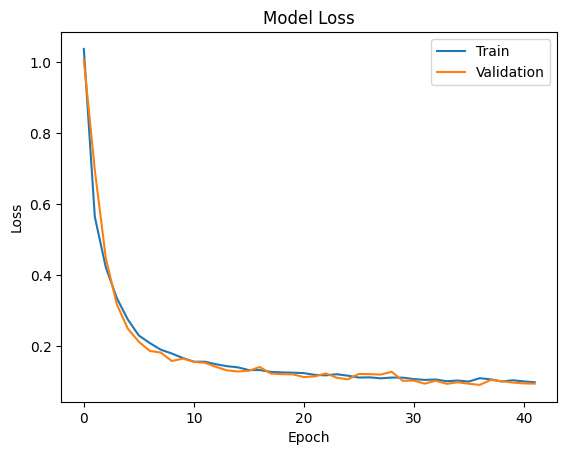

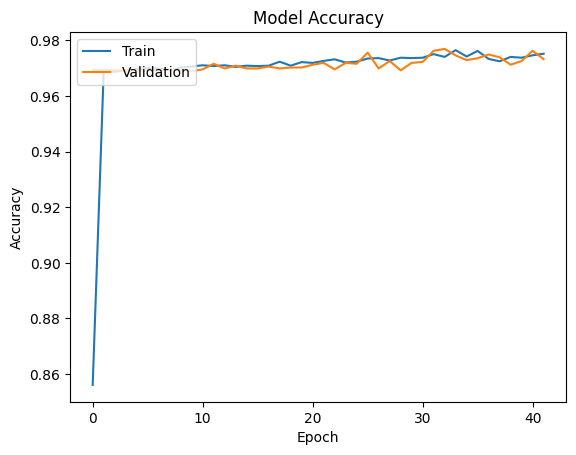

In [11]:
#  Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

#  Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#  Function to plot metrics
def plot_metric(history, metric, title, ylabel, loc='upper left'):
    if metric in history.history:
        plt.plot(history.history[metric], label='Train')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label='Validation')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend(loc=loc)
    plt.show()

#  Plot the curves
plot_metric(history, 'loss', 'Model Loss', 'Loss', loc='upper right')
plot_metric(history, 'accuracy', 'Model Accuracy', 'Accuracy')


**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





94/94 [==============================] - 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

  No failure       0.98      1.00      0.99      2899
         TWF       0.00      0.00      0.00        13
         HDF       0.00      0.00      0.00        32
         PWF       0.87      0.54      0.67        24
         OSF       1.00      0.26      0.41        23

    accuracy                           0.97      2991
   macro avg       0.57      0.36      0.41      2991
weighted avg       0.96      0.97      0.97      2991



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


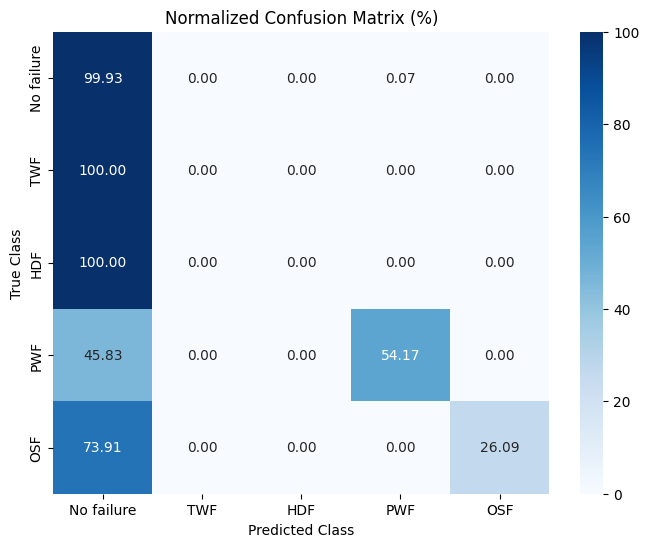

In [12]:
#  Make predictions (probabilities)
Y_pred_probs = model.predict(X_test)

#  Get the class with the highest probability (softmax) → final prediction
Y_pred = Y_pred_probs.argmax(axis=1)

#  Get the true classes
Y_true = Y_test.values.argmax(axis=1)

#  Class labels
labels = ['No failure', 'TWF', 'HDF', 'PWF', 'OSF']

#  Generate classification report
report = classification_report(Y_true, Y_pred, target_names=labels)
print("\nClassification Report:")
print(report)

#  Create confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

#  Normalize by row (percentage per true class)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

#  Plot 5x5 confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.title("Normalized Confusion Matrix (%)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


**ANALYSIS QUESTION** What do you observe? What can you conclude?

The model performs well in predicting when there are no failures, however, it struggles to predict when failures do occur. The predominant prediction tends to be 'no failure', due to the significantly larger number of no failure machines compared to those with failures.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [13]:
# Undersampling
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
X_resampled, y_no_failure = undersampler.fit_resample(X, Y['No failure'])
selected_indices = y_no_failure.index
Y_resampled = Y.iloc[selected_indices].copy()
Y_resampled = Y_resampled.apply(lambda row: (row == 1).astype(int), axis=1)

# Split with stratification
X_train_under, X_test_under, Y_train_under, Y_test_under = train_test_split(
    X_resampled, Y_resampled, test_size=0.2, random_state=42,
    stratify=Y_resampled.values.argmax(axis=1)
)

# Automatically compute class weights
y_integers = Y_train_under.values.argmax(axis=1)
classes = np.unique(y_integers)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_integers)
class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}

print(class_weight_dict)

print(X_train_under.shape, Y_train_under.shape, X_test_under.shape, Y_test_under.shape)

{0: 0.2601466992665037, 1: 6.08, 2: 2.503529411764706, 3: 3.325, 4: 3.432258064516129}
(1064, 8) (1064, 5) (266, 8) (266, 5)


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

I used undersampling together with class weight, where undersampling helps to reduce the large difference between the failure variables (TWF, HDF, PWF, OSF) and the machines without failures. Class weight, on the other hand, provides different weights during training, mainly adjusting the imbalance of TWF compared to the others.
I did not use SMOTE because, although it allowed the model to learn well during training with the generated samples, in practice the model tended to correctly predict mostly the synthetic data, showing poor generalization to real data.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [14]:
# Model for multi-class classification (5 exclusive outputs)
model = Sequential([
    Dense(64, kernel_regularizer=l2(0.01), input_shape=(X_train_under.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),

    Dense(32, kernel_regularizer=l2(0.01)),
    #BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),

    Dense(5, activation='softmax')  #  using softmax for exclusive multi-class
])

# Compilation with categorical_crossentropy
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.02),
    loss='categorical_crossentropy',           # one-hot multi-class
    metrics=['accuracy']
)

# Display the summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                576       
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32)                0         
                                                      

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/50
17/17 [==============================] - 2s 26ms/step - loss: 2.2052 - accuracy: 0.1137 - val_loss: 2.1166 - val_accuracy: 0.2331 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - 0s 7ms/step - loss: 1.8943 - accuracy: 0.2030 - val_loss: 2.1292 - val_accuracy: 0.1090 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 0s 8ms/step - loss: 1.7058 - accuracy: 0.2444 - val_loss: 2.0977 - val_accuracy: 0.1504 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 0s 7ms/step - loss: 1.6099 - accuracy: 0.2660 - val_loss: 2.0530 - val_accuracy: 0.2481 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 0s 8ms/step - loss: 1.4969 - accuracy: 0.3393 - val_loss: 1.9871 - val_accuracy: 0.3872 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 1.4702 - accuracy: 0.3919 - val_loss: 1.9284 - val_accuracy: 0.5038 - lr: 0.0010
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 1.3769 - 

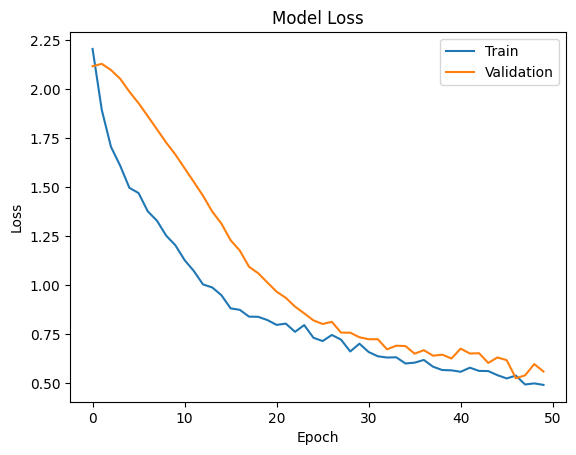

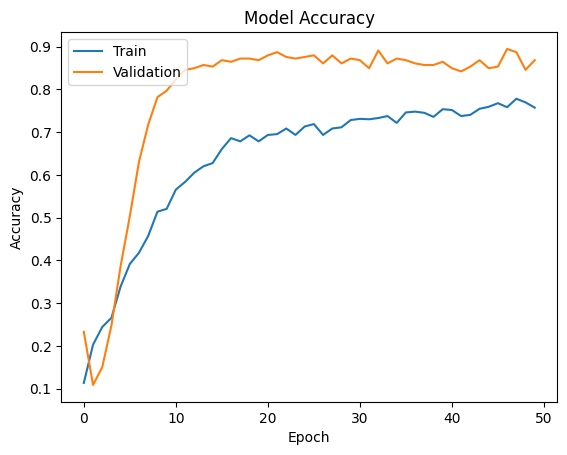

In [15]:
#  Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

#  Train the model
history = model.fit(
    X_train_under,
    Y_train_under,
    validation_data=(X_test_under, Y_test_under),
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#  Function to plot metrics
def plot_metric(history, metric, title, ylabel, loc='upper left'):
    if metric in history.history:
        plt.plot(history.history[metric], label='Train')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label='Validation')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend(loc=loc)
    plt.show()

#  Plot the curves
plot_metric(history, 'loss', 'Model Loss', 'Loss', loc='upper right')
plot_metric(history, 'accuracy', 'Model Accuracy', 'Accuracy')

#  Save test data and model
np.save('X_test_labels.npy', X_test_under)
Y_test_under = Y_test_under.astype(np.float32)
np.save('Y_test_labels.npy', Y_test_under)
model.save('model_test.h5')


**QUESTION** Plot the confusion matrix and the classification report

9/9 [==============================] - 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

  No failure       1.00      0.84      0.92       205
         TWF       0.35      1.00      0.52         8
         HDF       0.74      0.95      0.83        21
         PWF       0.70      1.00      0.82        16
         OSF       0.70      0.88      0.78        16

    accuracy                           0.87       266
   macro avg       0.70      0.93      0.77       266
weighted avg       0.92      0.87      0.88       266



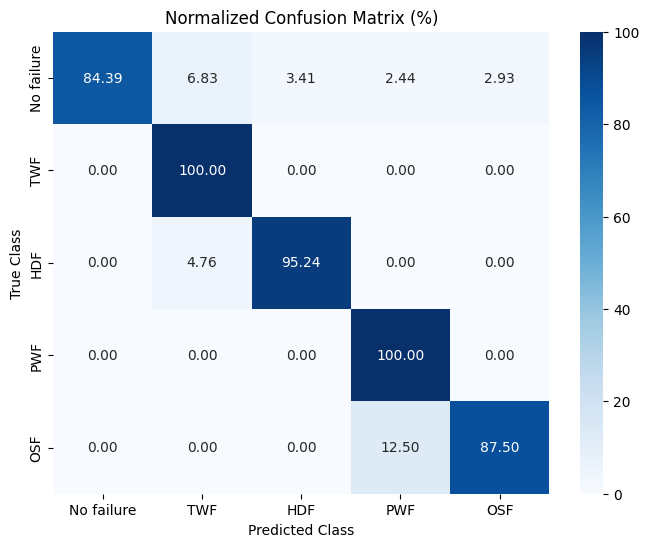

In [16]:
#  Make predictions as probabilities
Y_pred_probs = model.predict(X_test_under)

#  Get the class with the highest probability (softmax) → final prediction
Y_pred = Y_pred_probs.argmax(axis=1)

#  Get the true classes
Y_true = Y_test_under.values.argmax(axis=1)

#  Class labels
labels = ['No failure', 'TWF', 'HDF', 'PWF', 'OSF']

#  Generate classification report
report = classification_report(Y_true, Y_pred, target_names=labels)
print("\nClassification Report:")
print(report)

#  Create confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

#  Normalize by row (percentage per true class)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

#  Plot the 5x5 confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.title("Normalized Confusion Matrix (%)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


**ANALYSIS QUESTION** What do you observe? What can you conclude?

It was greatly improved compared to the data without balancing, since I removed a portion of the samples that had no failures, as their number was too high compared to the machines that had failures.
As previously mentioned, I used class weight to penalize or not certain samples during training, but even so, I was not able to balance the predictions for TWF, as the recall is very high while the precision is low, this indicates that there are many false positives, which I believe is due to the use of class weight.
In any case, the overall model showed an accuracy above 80%, being able to predict the types of failures with greater precision.